In [87]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import chirp, spectrogram, convolve, find_peaks, savgol_filter
from scipy.io import wavfile
import sounddevice as sd
import subprocess

from utilities import *
from frft import *

In [2]:
# constellation_map = {
#     '00' : complex(1/np.sqrt(2), 1/np.sqrt(2)),
#     '01' : complex(-1/np.sqrt(2), 1/np.sqrt(2)),
#     '11' : complex(-1/np.sqrt(2), -1/np.sqrt(2)),
#     '10' : complex(1/np.sqrt(2), -1/np.sqrt(2)),
# }
constellation_map = {
    0: 1,
    1: -1,
}

QAM_symbols = np.array([*constellation_map.values()])
QAM_bits = np.array([*constellation_map.keys()])

In [3]:
N = 8192
L = 1024

np.random.seed(0)
source = np.random.choice(list(constellation_map.values()), (N-2)//2)
subcarrier_data = np.concatenate(([0], source, [0], np.conjugate(np.flip(source))))
x = np.fft.ifft(subcarrier_data).real
OFDM_symbol = np.concatenate((x[-L:], x))
OFDM_symbol /= np.max(np.abs(OFDM_symbol))

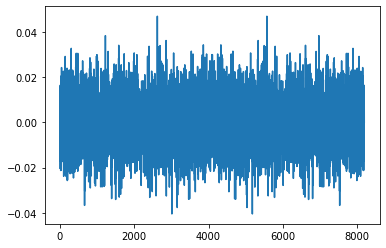

In [4]:
plt.plot(x)

In [77]:
fs = 48000

t = np.linspace(0,1,fs)
chirp_standard = chirp(t, 1e3, 1, 10e3, method='linear')

pause = np.zeros(fs)

np.random.seed(1)
whitenoise = np.random.randn(fs)
whitenoise /= np.max(np.abs(whitenoise))

standard = np.concatenate([pause, chirp_standard, pause, whitenoise, pause])

OFDM_frame = np.tile(OFDM_symbol, 10)
signal = np.concatenate([standard, OFDM_frame])

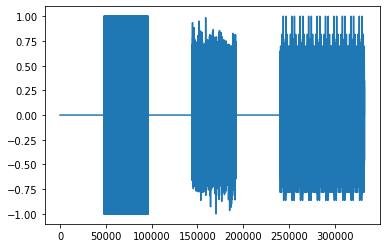

In [6]:
plt.plot(signal)

In [7]:
sd.play(signal, samplerate=fs, blocking=True)
write('OFDM/test_frame.wav', fs, signal)

In [8]:
#subprocess.Popen(["afplay", "OFDM/test_frame.wav"])
#received = sd.rec(len(signal), samplerate = fs, channels = 1, blocking = True).flatten()
#write('OFDM/received_frame.wav', fs, received)
received = np.array(read('OFDM/received_frame.wav', fs)[1])

# MUST CHANGE LATER! DEBUGGING ONLY
#received = signal

In [9]:
def synchronise(received_chirp, transmitted_chirp):
    def window(x):
        return x * np.hanning(len(x))
    
    conv = convolve(window(received_chirp), np.flip(window(transmitted_chirp)), mode='same')
    
    return np.argmax(np.abs(conv))

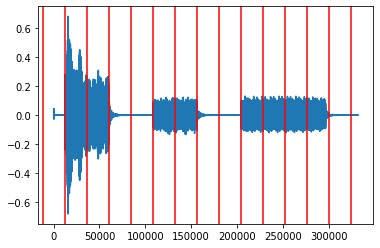

In [10]:
%matplotlib inline
plt.plot(received)
start = synchronise(received, chirp_standard)
for i in range(-2,13):
    plt.axvline(x=start+i*fs//2, c='r')
plt.show()

In [11]:
%matplotlib qt
fig = plt.figure(figsize=(17,5), dpi=150)
plt.rcParams.update({'font.size': 14})

plt.subplot(1,3,1)
plt.plot(signal)
plt.xlabel('Sample index')
plt.ylabel('Signal')
plt.title('Transmitted signal\n(chirp + whitenoise + OFDM frame)')
plt.locator_params(axis='x', nbins=4)

plt.subplot(1,3,2)
plt.plot(convolve(window(received), np.flip(window(chirp_standard)), mode='same'))
plt.xlabel('Sample index')
plt.title('Convolution of chirp\nwith inverse chirp')
plt.locator_params(axis='x', nbins=4)

plt.subplot(1,3,3)
plt.plot(received)
for i in range(-2,13):
    plt.axvline(x=start+i*fs//2, c='r')
plt.xlabel('Sample index')
plt.title('Received signal\nwith synchronisation from chirp')
plt.locator_params(axis='x', nbins=4)

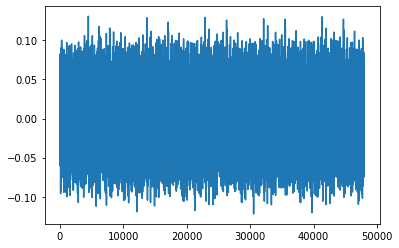

In [12]:
%matplotlib inline
received_frame = received[start+int(3.5*fs):start+int(4.5*fs)]
plt.plot(received_frame)

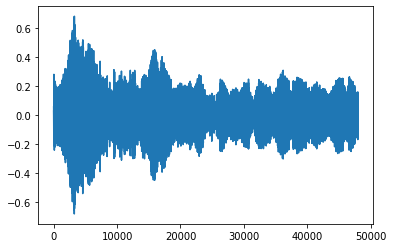

In [13]:
received_chirp = received[start-int(0.5*fs):start+int(0.5*fs)]
plt.plot(received_chirp)

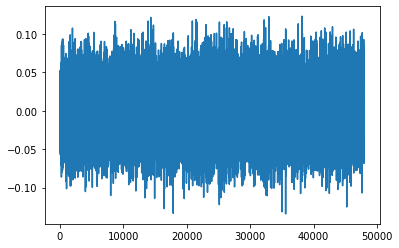

In [14]:
received_whitenoise = received[start+int(1.5*fs):start+int(2.5*fs)]
plt.plot(received_whitenoise)

## FrFT Channel estimation

In [201]:
res = optimise_a(chirp_standard)
res

     fun: -83.4300435978929
 message: 'Solution found.'
    nfev: 23
  status: 0
 success: True
       x: 1.118010721541389

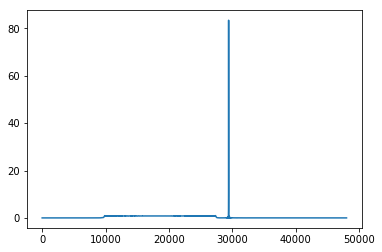

In [202]:
plt.plot(np.abs(frft(chirp_standard, res.x)))

## White noise channel estimation

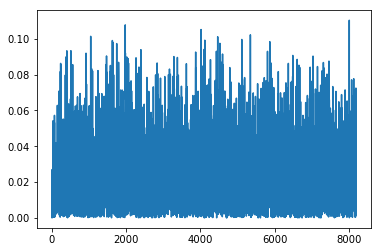

In [70]:
plt.plot(np.abs(received_whitenoise)[:N])
# plt.xscale('log')
# plt.yscale('log')

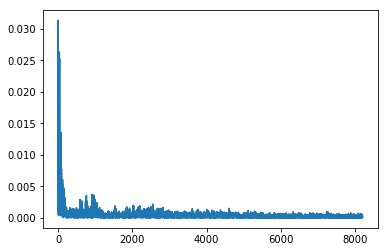

In [71]:
plt.plot(np.abs(np.fft.ifft(np.fft.fft(received_whitenoise)/np.fft.fft(whitenoise)))[:N])

## Known OFDM Channel Estimation

In [101]:
# Gets the end index of the synchronisation chirp
def synchronise(received_signal, transmitted_chirp):
    def window(x): return x * np.hanning(len(x))
    
    c = convolve(window(received_signal), np.flip(window(transmitted_chirp)), mode='same')
#     plt.plot(c)
    return np.argmax(np.abs(c))


# Gets the channel estimate from the known OFDM symbols
def get_channel_estimate(known_symbol, received_symbols, num_symbols):
    
    R = np.zeros((num_symbols, known_symbol.size), dtype=complex)

    for i in range(num_symbols):
        r = received_symbols[L+i*(N+L):(i+1)*(L+N)]
        R[i,:] = np.fft.fft(r)

    H_est = np.mean(R, axis = 0)/known_symbol
    
    return H_est


# Plots the channel frequency response and phase
def plot_channel(H):
    fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize = (15, 5))

    ax_left.plot(10*np.log10(np.abs(H)))
    ax_left.set_title('Magnitude [dB]')

    ax_right.plot(np.angle(H))
    ax_right.set_title('Phase [rad]')

In [102]:
# Set up parameters in this box

fs = 48000  # Sampling frequency
N = 8192    # OFDM symbol length
L = 1024    # Cyclic prefix length

# constellation_map = {
#     '00' : complex(1/np.sqrt(2), 1/np.sqrt(2)),
#     '01' : complex(-1/np.sqrt(2), 1/np.sqrt(2)),
#     '11' : complex(-1/np.sqrt(2), -1/np.sqrt(2)),
#     '10' : complex(1/np.sqrt(2), -1/np.sqrt(2)),
# }
constellation_map = {
    0: 1,
    1: -1,
}

QAM_symbols = np.array([*constellation_map.values()])
QAM_bits = np.array([*constellation_map.keys()])

In [103]:
# Create known OFDM symbol in this box
# Known OFDM symbol randomly chooses from the available constellation values

n_reps = 10    # Number of times to repeat the symbol

np.random.seed(0)    # Makes the random choices the same each time
source = np.random.choice(list(constellation_map.values()), (N-2)//2)
subcarrier_data = np.concatenate(([0], source, [0], np.conjugate(np.flip(source))))

x = np.fft.ifft(subcarrier_data).real
OFDM_symbol = np.concatenate((x[-L:], x))
OFDM_symbol /= np.max(np.abs(OFDM_symbol))

OFDM_frame = np.tile(OFDM_symbol, n_reps)

In [104]:
# Create transmitted signal in this box
# Signal is 1 second silence, then 1 second chirp, then known OFDM symbol

t = np.linspace(0,1,fs)
chirp_standard = chirp(t, 1e3, 1, 10e3, method='linear')

pause = np.zeros(fs)

signal = np.concatenate([pause, chirp_standard, OFDM_frame])

In [112]:
# Toy channel 1: no channel
# Expect to see a perfectly flat channel frequency response and phase

received = signal

chirp_end_index = synchronise(received, chirp_standard) + fs//2

received_symbols = received[chirp_end_index:chirp_end_index + n_reps*(L+N)]

H_est = get_channel_estimate(subcarrier_data, received_symbols, n_reps)

plot_channel(H_est)

/tmp/ipykernel_8574/3616224622.py:19: RuntimeWarning: divide by zero encountered in true_divide
  H_est = np.mean(R, axis = 0)/known_symbol
/tmp/ipykernel_8574/3616224622.py:19: RuntimeWarning: invalid value encountered in true_divide
  H_est = np.mean(R, axis = 0)/known_symbol


In [119]:
# Toy channel 2: arbirtary channel
# Choose an arbitrary channel to make sure the estimator can recover the channel perfectly

h_toy = 10 - np.arange(10)
received = np.convolve(signal, h_toy)
# plt.plot(received)

chirp_end_index = synchronise(received, chirp_standard) + fs//2 - 1

received_symbols = received[chirp_end_index:chirp_end_index + n_reps*(L+N)]

H_est = get_channel_estimate(subcarrier_data, received_symbols, n_reps)
plot_channel(H_est)

plot_channel(np.fft.fft(h_toy, n=N))

/tmp/ipykernel_8574/3616224622.py:19: RuntimeWarning: divide by zero encountered in true_divide
  H_est = np.mean(R, axis = 0)/known_symbol
/tmp/ipykernel_8574/3616224622.py:19: RuntimeWarning: invalid value encountered in true_divide
  H_est = np.mean(R, axis = 0)/known_symbol


## Decoding

In [29]:
received_frame

array([-0.01267572, -0.00106297,  0.00501072, ...,  0.02946023,
        0.0461041 ,  0.01020162], dtype=float32)

In [30]:
r = received_frame[L:(L+N)]

/tmp/ipykernel_8574/3378942797.py:3: RuntimeWarning: invalid value encountered in true_divide
  Xhat = R/H # deconvolution


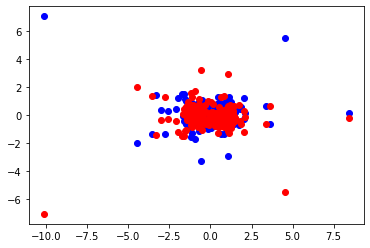

In [31]:
%matplotlib inline
R = np.fft.fft(r)
Xhat = R/H # deconvolution

plt.scatter(Xhat.real[N//2:], Xhat.imag[N//2:], color = 'blue')
plt.scatter(Xhat.real[:N//2], Xhat.imag[:N//2], color = 'red')

## Convolution channel estimation

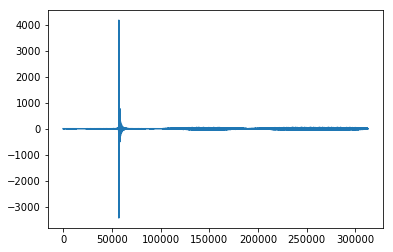

In [148]:
%matplotlib inline
conv = convolve(received, np.flip(chirp_standard), mode='same')
plt.plot(conv)

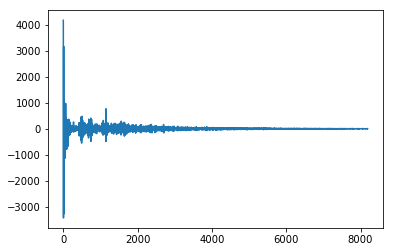

In [111]:
%matplotlib inline
impulse = conv[start:start+N]
plt.plot(conv[start:start+N])

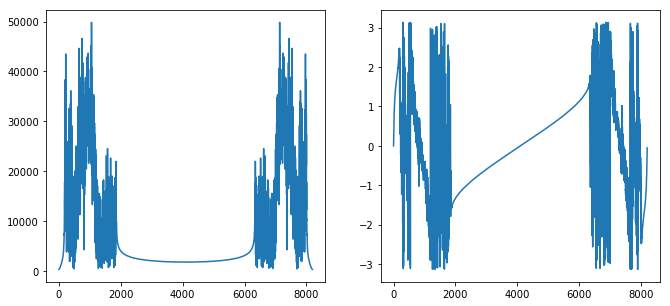

In [112]:
H = np.fft.fft(impulse)
plt.subplots(figsize=(11,5))
plt.subplot(1,2,1)
plt.plot(np.abs(H))
plt.subplot(1,2,2)
plt.plot(np.angle(H))

In [96]:
from scipy.signal import find_peaks

/Users/matthewbarker/opt/anaconda3/envs/scienv/lib/python3.7/site-packages/ipykernel_launcher.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  This is separate from the ipykernel package so we can avoid doing imports until


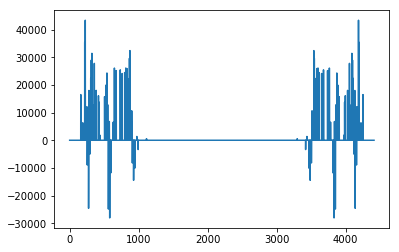

In [97]:
peaks, _ = find_peaks(np.abs(H), prominence=0.5, width=3)
H_smooth = np.zeros(len(H))
H_smooth[peaks] = H[peaks]
plt.plot(H_smooth)

Text(0.5, 1.0, 'Impulse response (chirp cross-correlation)')

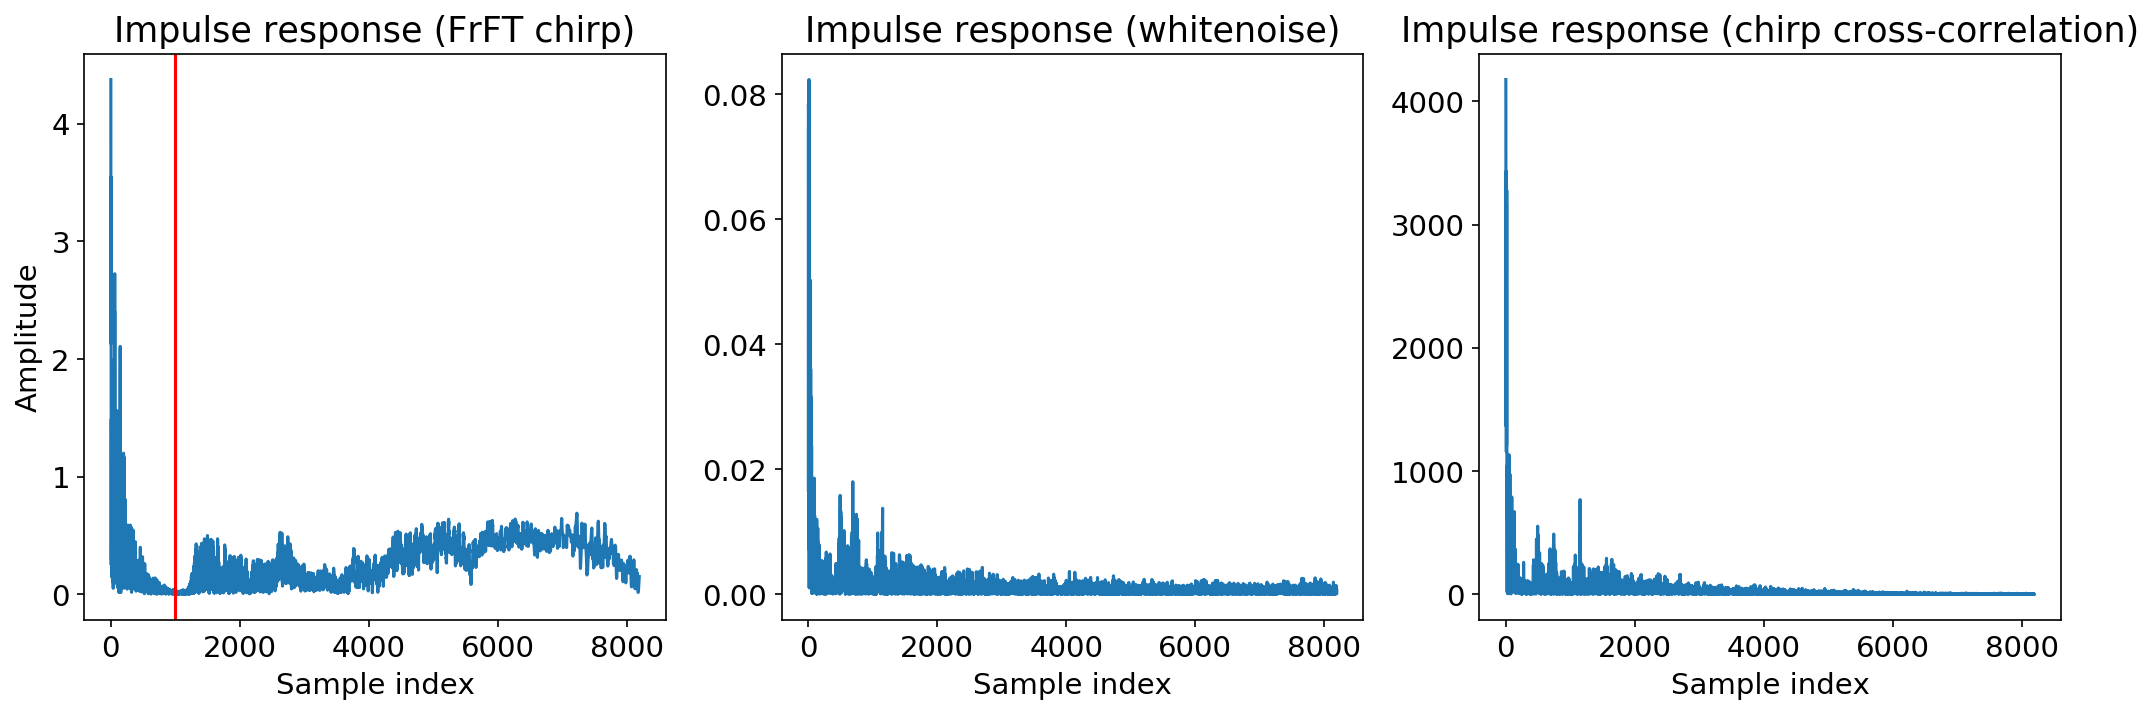

In [173]:
fig = plt.figure(figsize=(17,5), dpi=150)
plt.rcParams.update({'font.size': 14})

plt.subplot(1,3,1)
peak= np.argmax(Y_alpha_opt_t)
h = Y_alpha_opt_t[peak:peak+N]
plt.plot(np.abs(h))
plt.axvline(1000, c='r')
plt.xlabel('Sample index')
plt.ylabel('Amplitude')
plt.title('Impulse response (FrFT chirp)')

plt.subplot(1,3,2)
plt.plot(np.abs(np.fft.ifft(np.fft.fft(received_whitenoise)/np.fft.fft(whitenoise)))[:N])
plt.xlabel('Sample index')
plt.title('Impulse response (whitenoise)')

plt.subplot(1,3,3)
plt.plot(np.abs(conv[start:start+N]))
plt.xlabel('Sample index')
plt.title('Impulse response (chirp cross-correlation)')